In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [2]:
orbital_names = {
    (1, 0, 0): "1s",
    (2, 0, 0): "2s",
    (2, 1, 0): "2p_z",
    (2, 1, -1): "2p_y",
    (2, 1, 1): "2p_x",
    (3, 0, 0): "3s",
    (3, 1, 0): "3p_z",
    (3, 1, -1): "3p_y",
    (3, 1, 1): "3p_x",
    (3, 2, 0): "3d_z2",
    (3, 2, -1): "3d_yz",
    (3, 2, 1): "3d_xz",
    (3, 2, -2): "3d_xy",
    (3, 2, 2): "3d_x2-y2",
    (4, 0, 0): "4s",
    (4, 1, 0): "4p_z",
    (4, 1, -1): "4p_y",
    (4, 1, 1): "4p_x",
    (4, 2, 0): "4d_z2",
    (4, 2, -1): "4d_yz",
    (4, 2, 1): "4d_xz",
    (4, 2, -2): "4d_xy",
    (4, 2, 2): "4d_x2-y2",
    (4, 3, 0): "4f_z3",
    (4, 3, -1): "4f_yz2",
    (4, 3, 1): "4f_xz2",
    (4, 3, -2): "4f_xyz",
    (4, 3, 2): "4f_x(x2-3y2)",
    (4, 3, -3): "4f_y(3x2-y2)",
    (4, 3, 3): "4f_x3-3xy2",
}

def make_psi(n, l, m):
    return lambda r, theta, phi: r**l * np.exp(-r/n) * sp.special.genlaguerre(n-l-1, 2*l+1)(2*r/n) * sp.special.sph_harm_y(l, m, theta, phi)

In [3]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def plane_cartesian_to_spherical(x, y, plane=0):
    match plane:
        case 0: point = (x, y, 0)  # XY plane
        case 1: point = (0, x, y)  # YZ plane
        case 2: point = (y, 0, x)  # ZX plane
    return cartesian_to_spherical(*point)

In [4]:
def sample_distribution(orbital_func, n_samples=10000, plane=0):

    # Find the max
    max = 0
    for i in range(10000):
        x, y = np.random.uniform(-60, 60, size=2)
        r, theta, phi = plane_cartesian_to_spherical(x, y, plane)
        value = abs(orbital_func(r, theta, phi))**2
        if value > max:
            max = value

    # Find the bounds
    bound = 60
    while True:
        r, theta, phi = plane_cartesian_to_spherical(bound, bound, plane)
        value = abs(orbital_func(r, theta, phi))**2
        if value >= max * 0.0001:
            bound += 1
            break
        else:
            bound -= 1

    print(max, bound)

    # Make the samples
    pool = ThreadPoolExecutor(max_workers=8)
    futures = [pool.submit(generate_samples, n_samples // 8, bound, max, orbital_func, plane) for _ in range(8)]
    samples = np.vstack([future.result() for future in futures])
    return samples


def generate_samples(n_samples, bound, max, orbital_func, plane):
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.uniform(-bound, bound, size=2)
        r, theta, phi = plane_cartesian_to_spherical(x, y, plane)
        value = abs(orbital_func(r, theta, phi))**2
        threshold = np.random.uniform(0, max)
        if threshold < value:
            samples.append((x, y))
    return np.array(samples)


0.05861971157470256 4
0.03689474880426058 4
0.013416560226331812 4


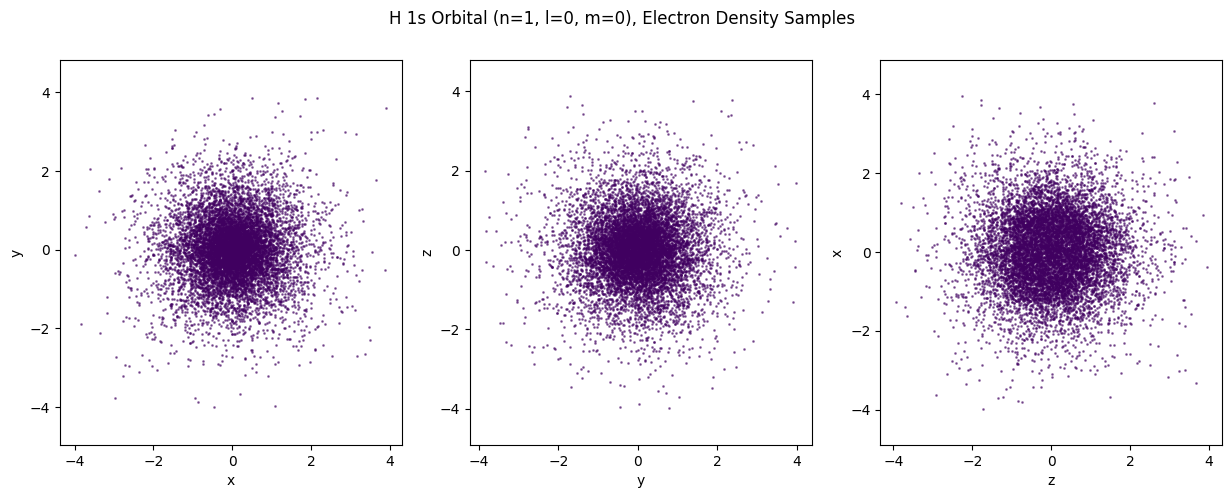

0.07240266794666497 11
0.1149121176372473 10
0.03754873088363025 11


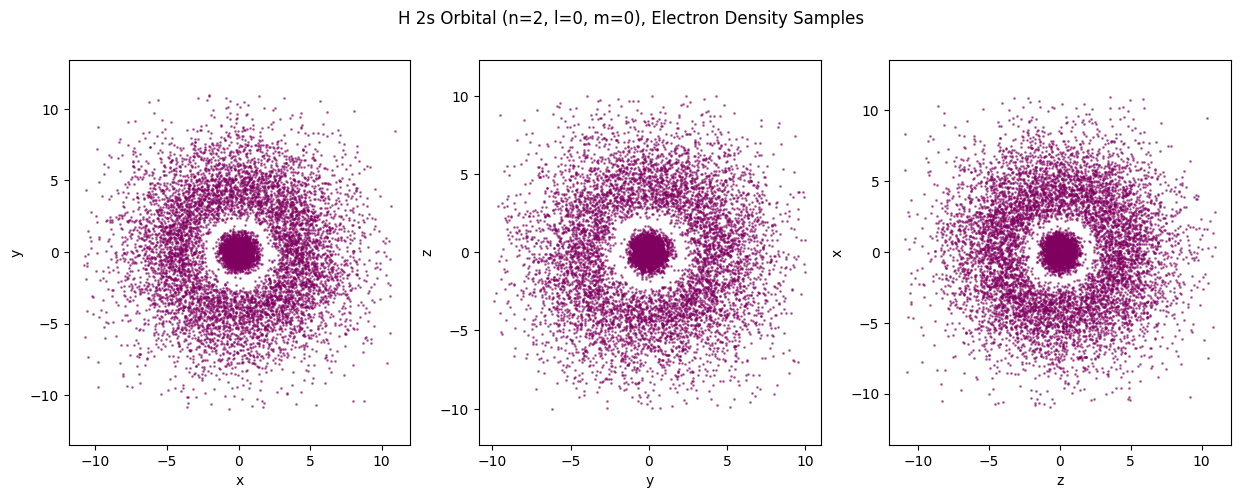

4.845555763527977e-34 11
0.11246756937421395 11
0.12335178786937925 11


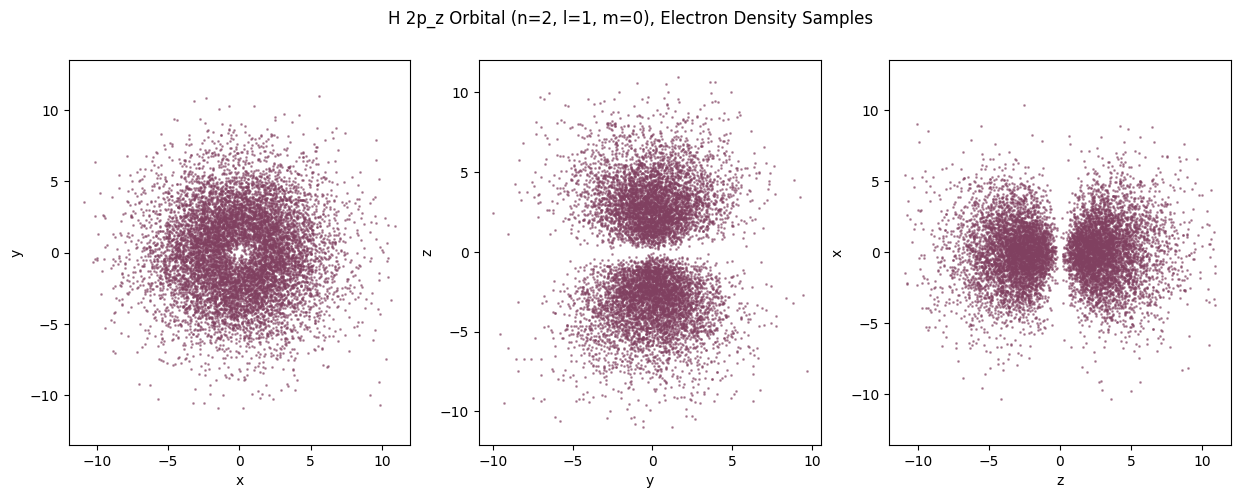

0.06455079494977327 11
0.06052291594112728 11
0.06323112217099294 11


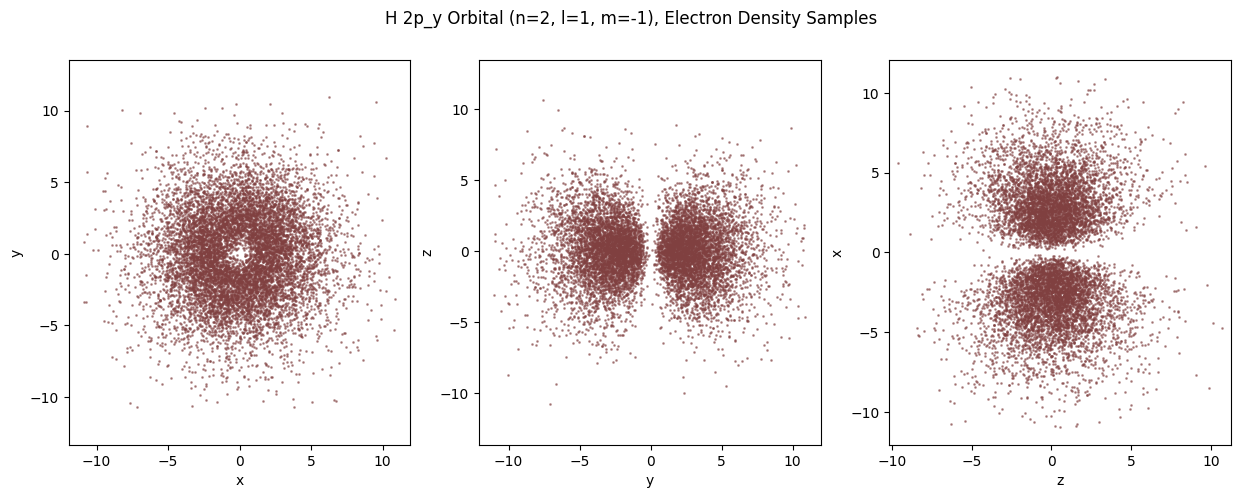

0.06457531739969925 11
0.06252283426548891 11
0.06309517995053127 11


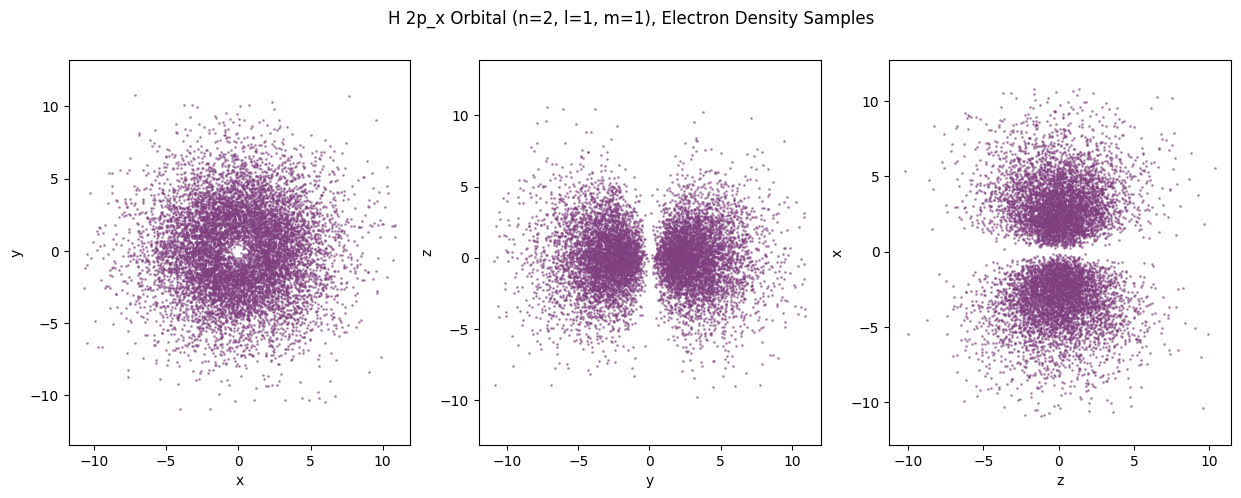

0.03808492834154662 22
0.02402693446738031 22
0.643938789686909 17


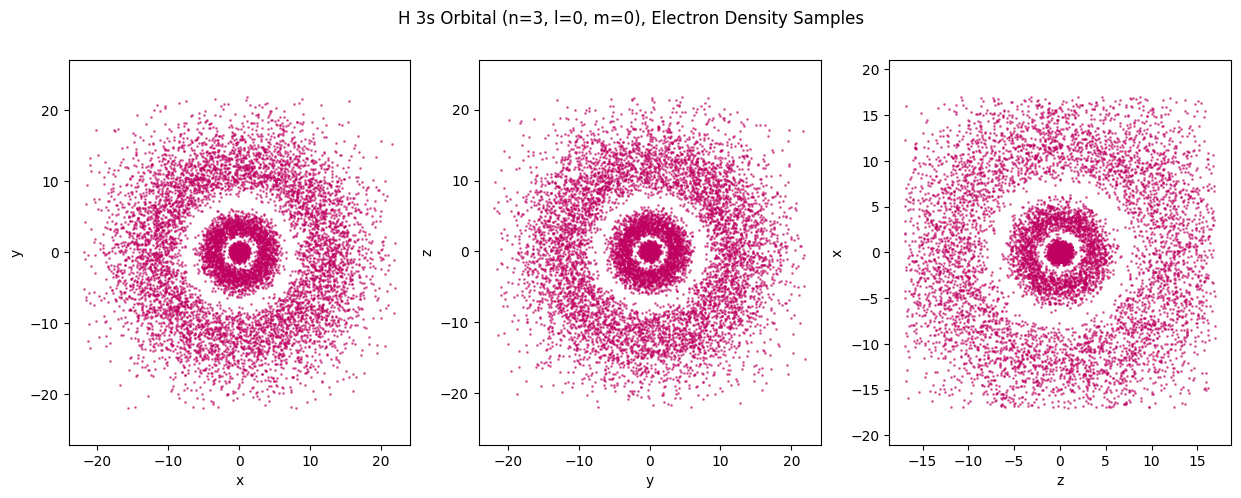

6.551890389751428e-33 21
1.8085786634589889 20
1.723666219091425 20


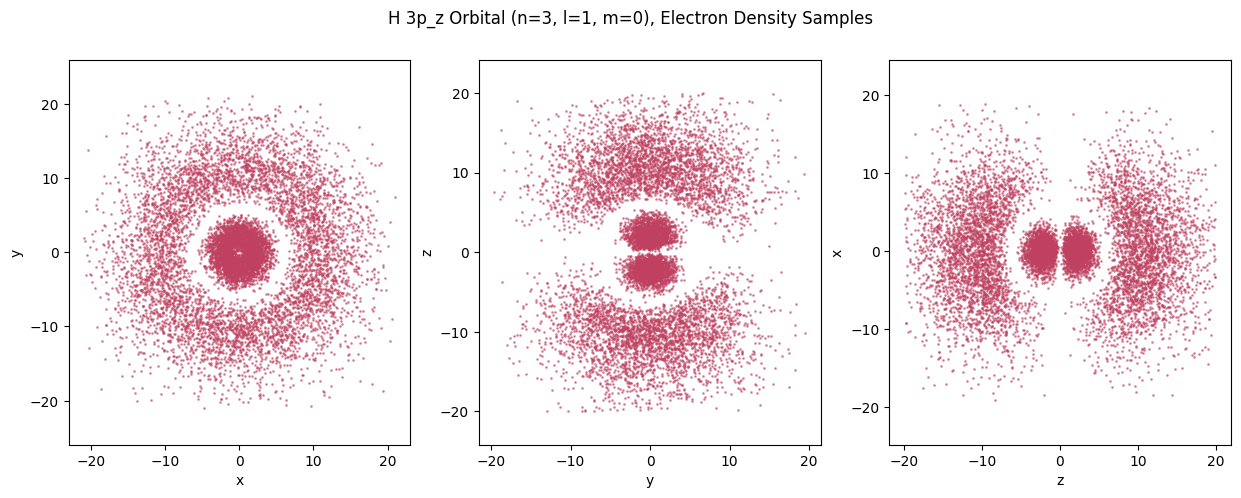

0.9092737118064373 21
0.9118120244867428 20
0.9088848778978752 20


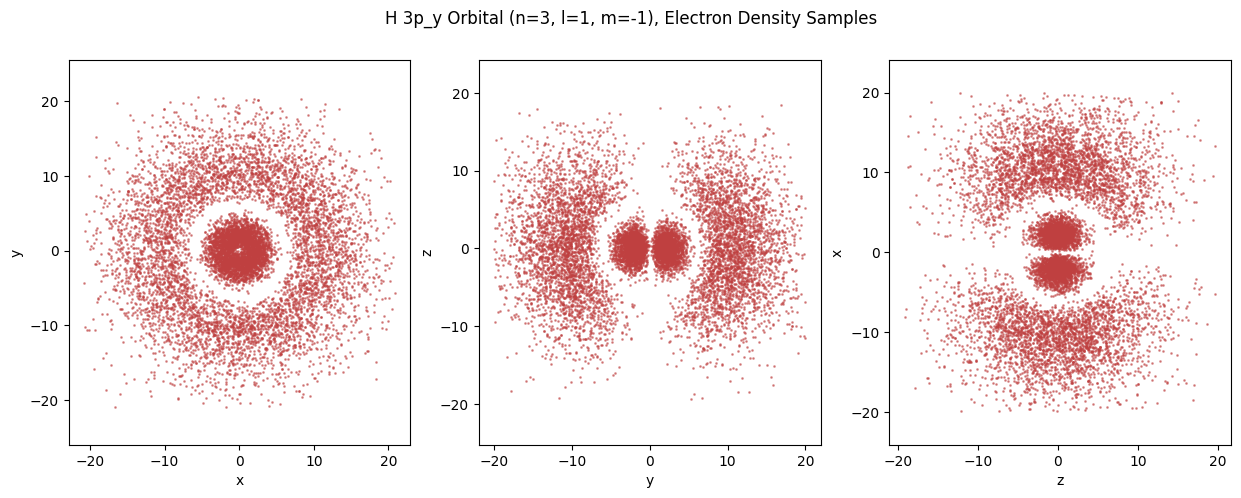

0.9120907667165324 21
0.8918571045143175 20
0.9004018177589983 20


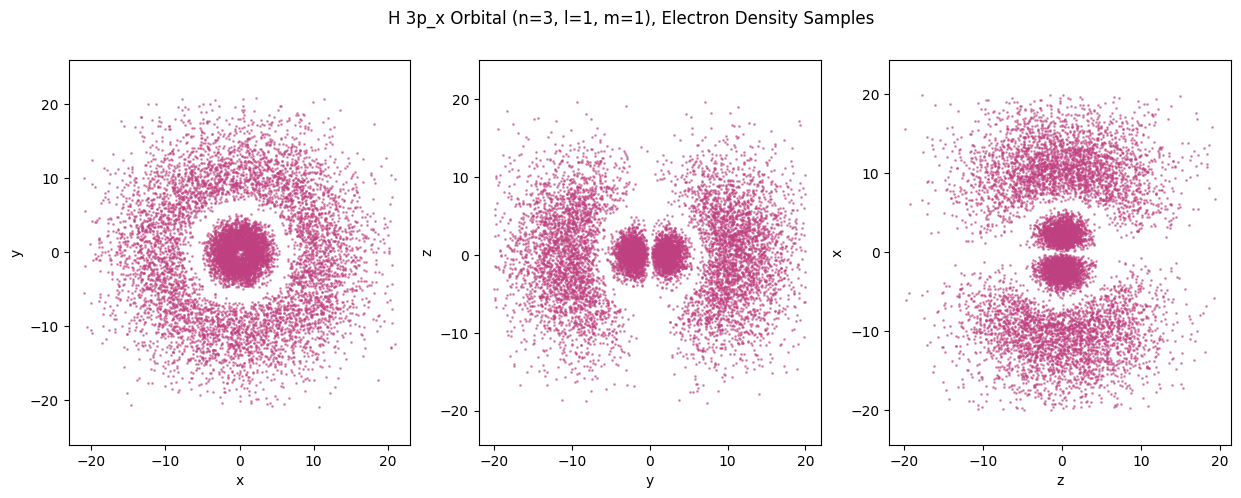

2.3611428837032706 21
9.279426346982373 17
9.330939154873755 17


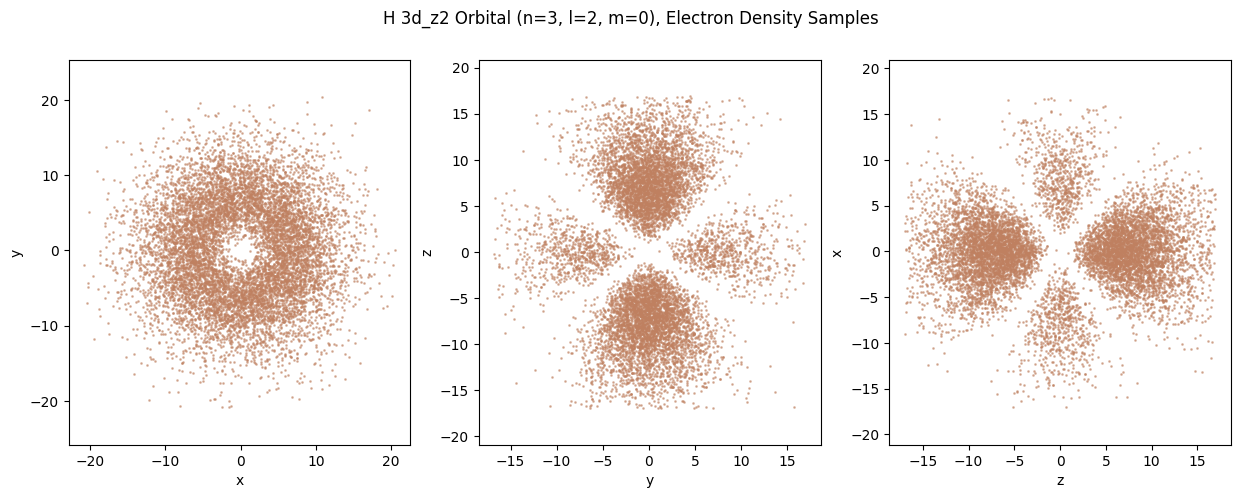

5.311780697134822e-32 21
3.5258878209909756 21
3.4711233443747185 21


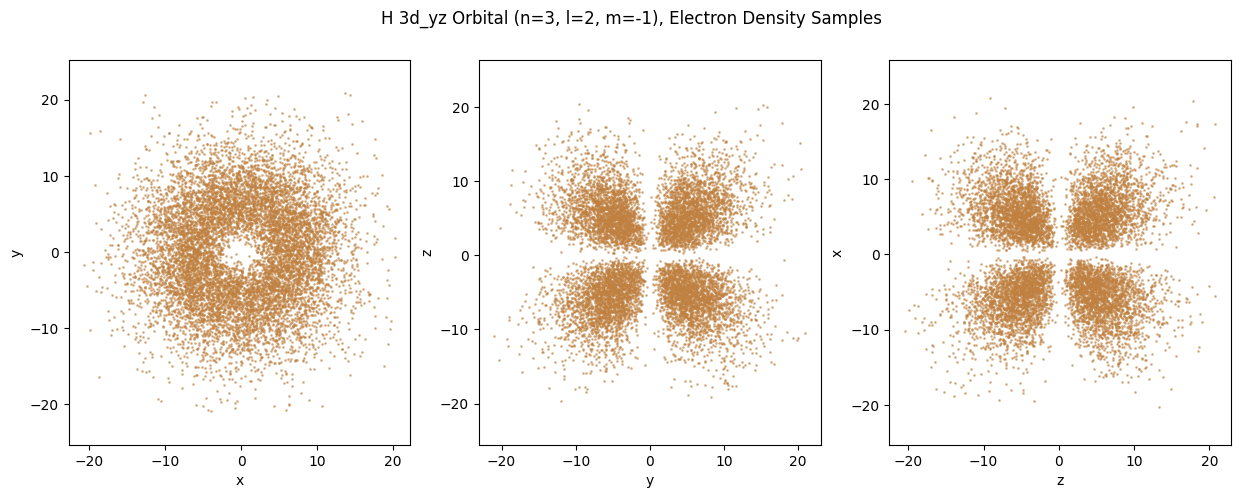

5.311773547454371e-32 21
3.512107392777547 21
3.538005652241591 21


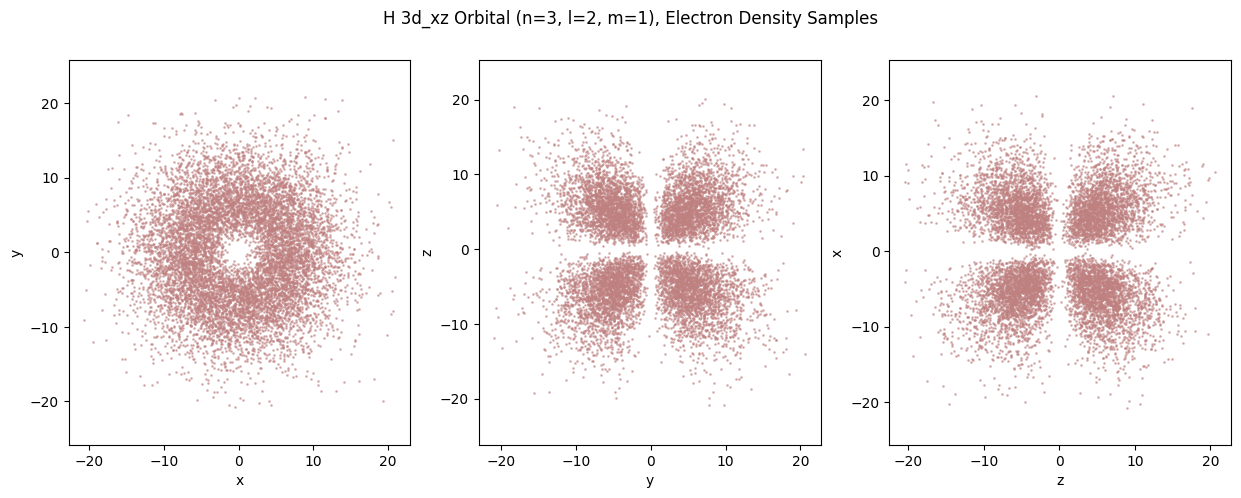

3.541743758295019 21
3.4219061396797605 19
3.474509307700306 19


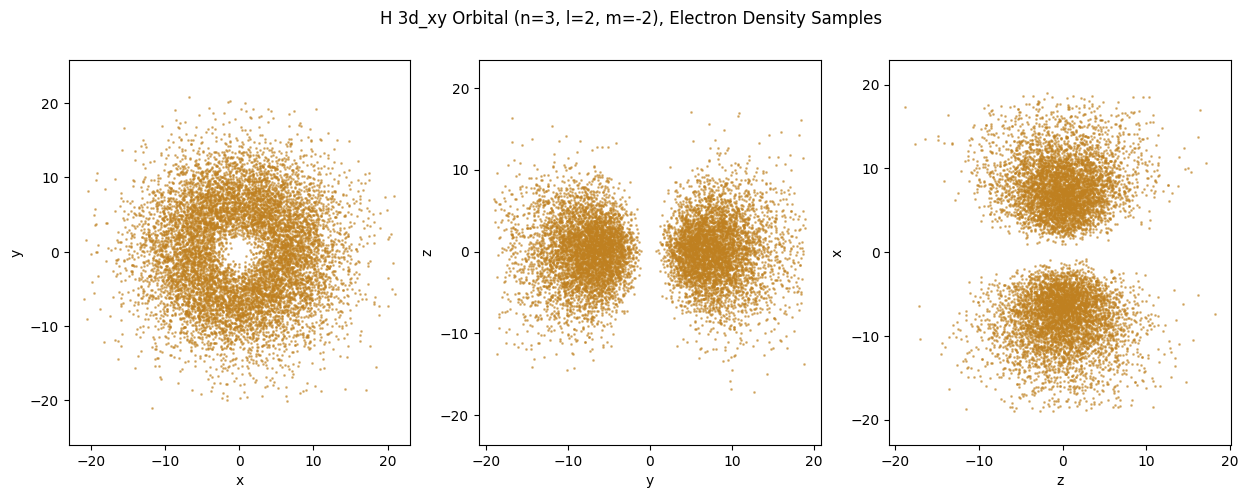

3.5417365023880456 21
3.4987183955804833 19
3.5400609625367268 19


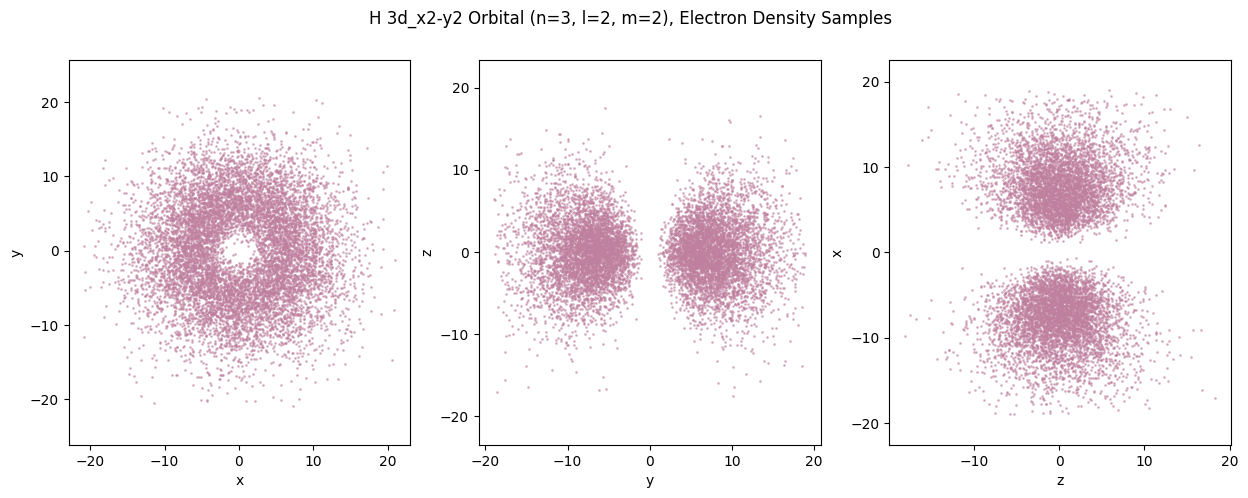

0.18451036561773734 32
0.6265969543643874 29
0.1549246298871051 32


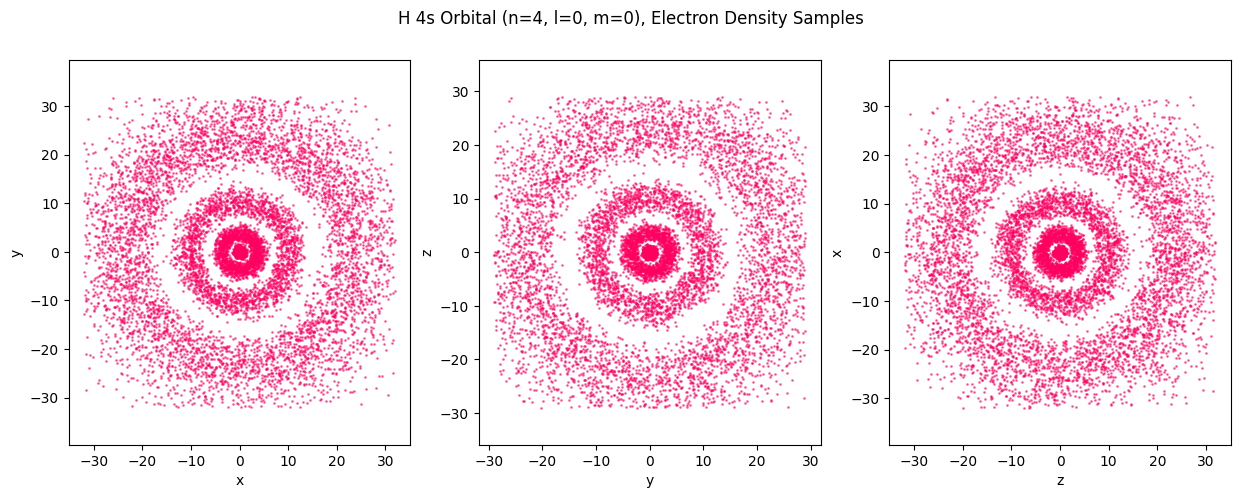

4.1212595199773576e-32 33
10.664915304690183 32
10.314625767617693 32


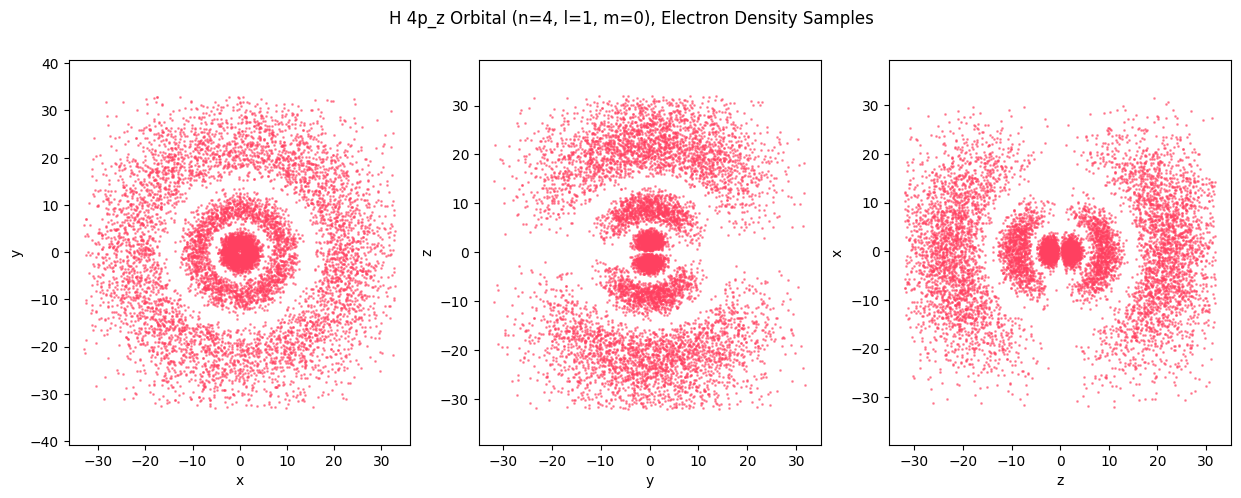

5.503879099208734 33
4.885279657524111 32
5.324940852674542 32


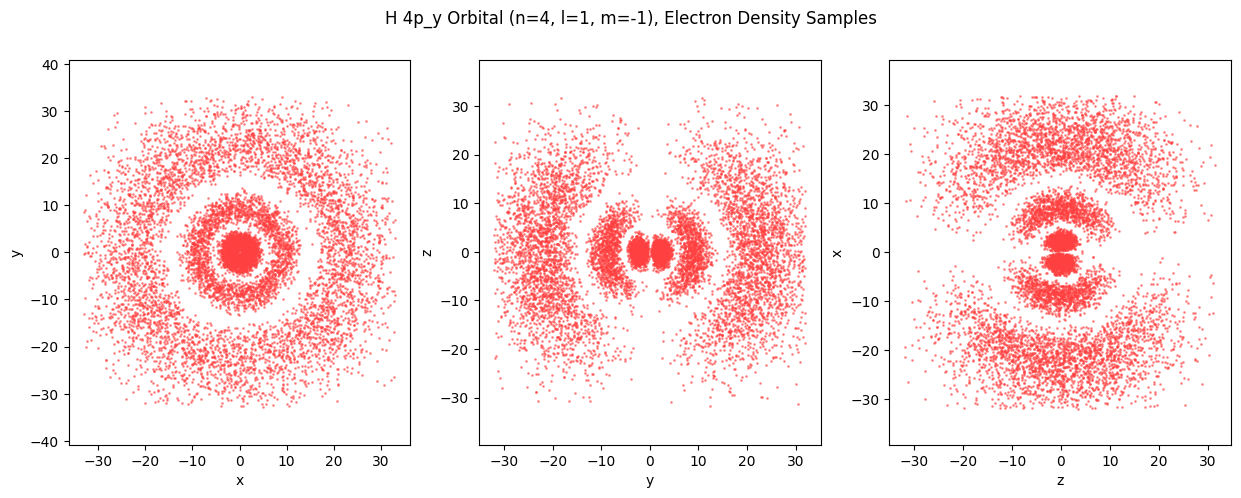

5.498766644540551 33
5.4989723931851975 32
5.318931475135587 32


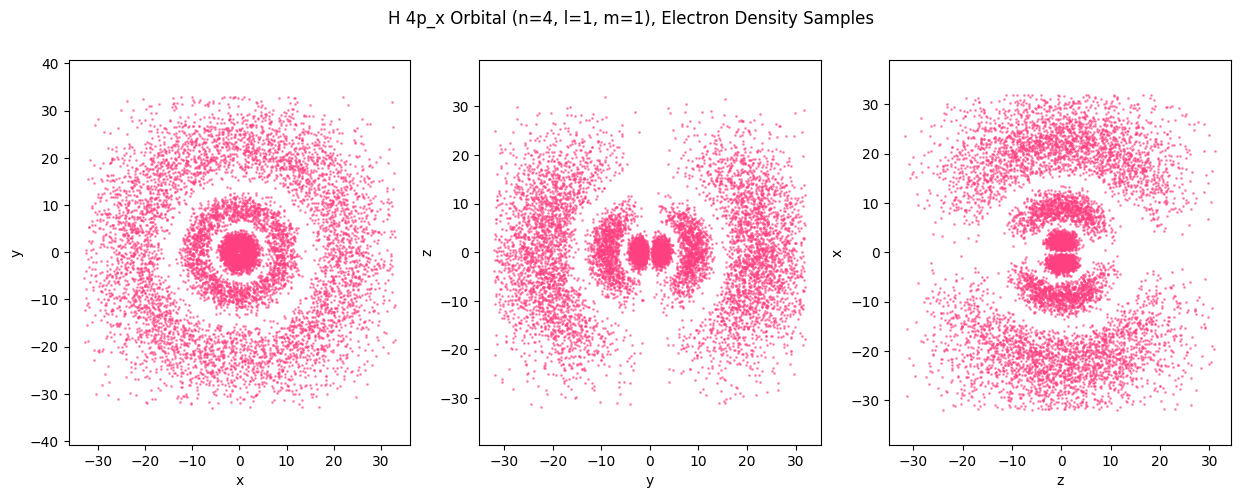

62.54557655505934 35
247.25809781358427 29
240.93583855899342 29


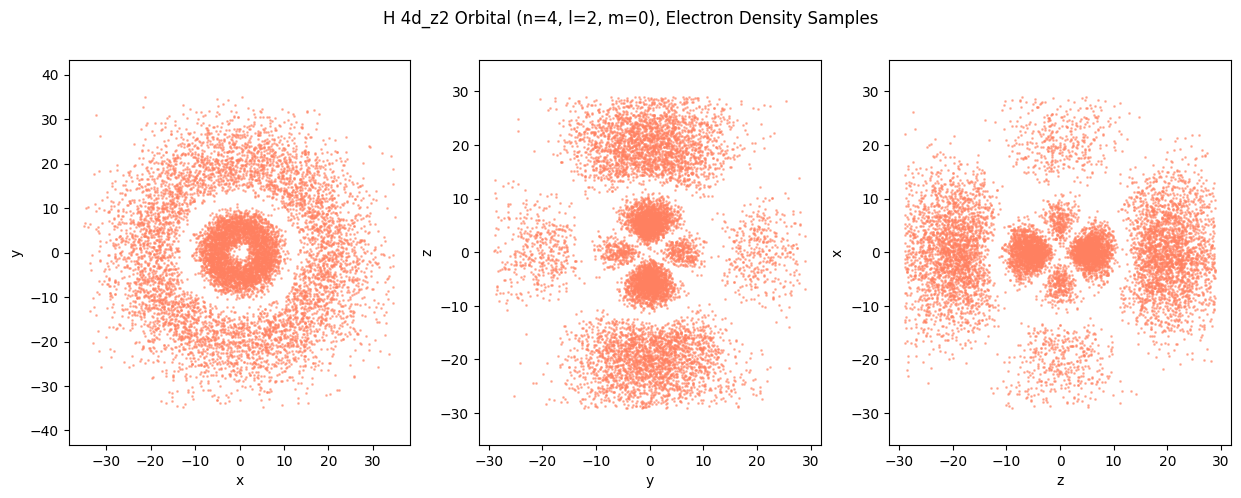

1.4070300957355571e-30 35
93.74148503415691 35
90.73955411411899 35


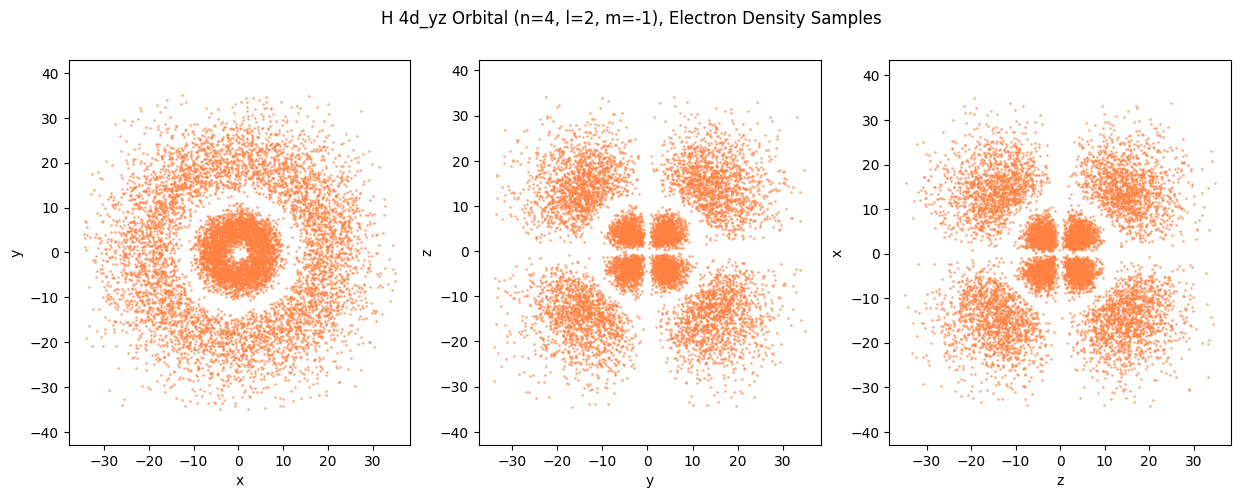

1.4070596591045861e-30 35
93.0999967617802 35
90.176813866423 35


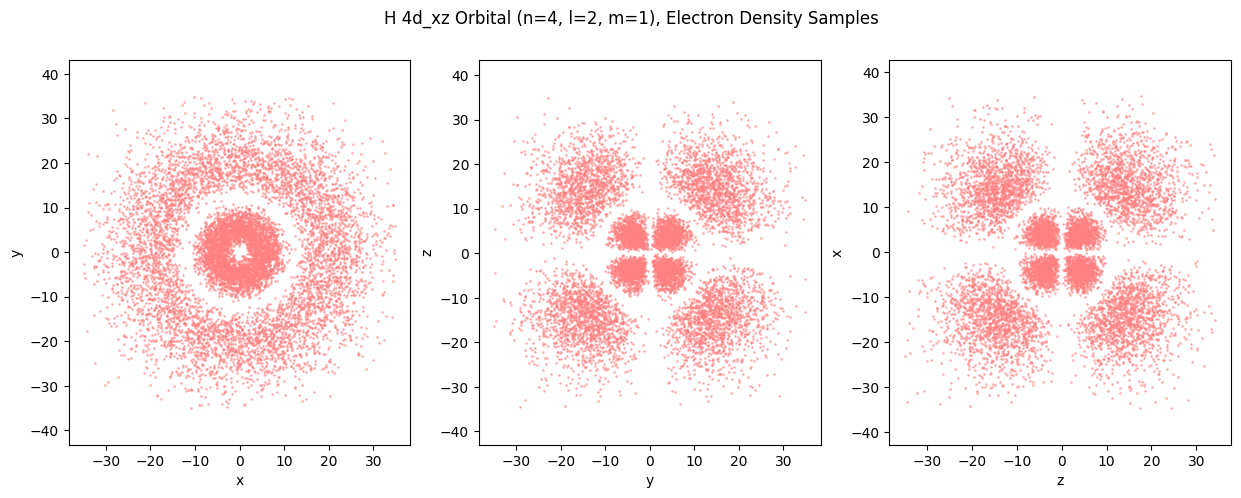

93.81876555708041 35
91.12633657711179 32
93.71204716926344 32


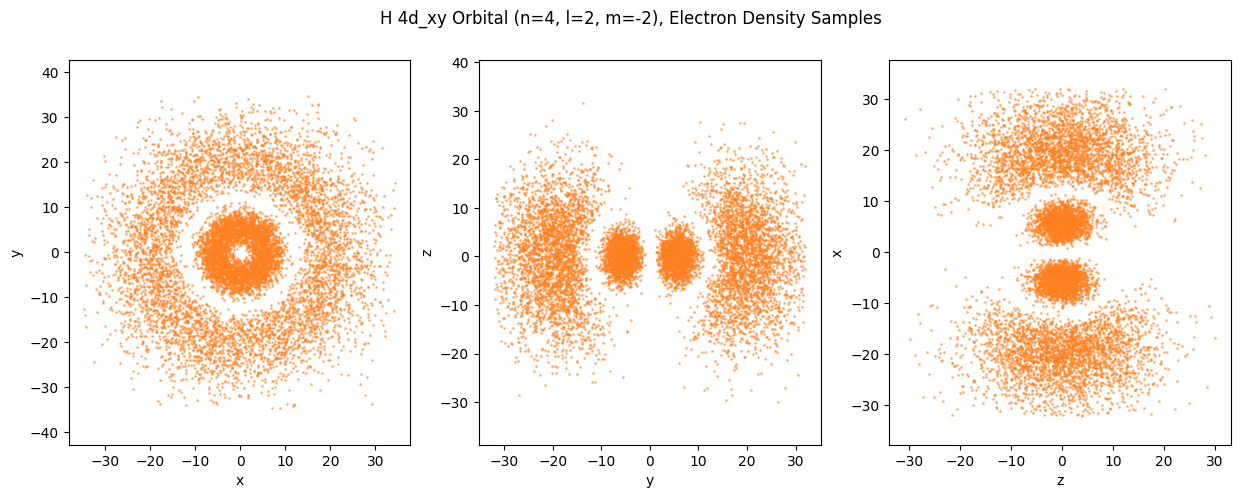

93.81905729005848 35
93.74632634818103 32
91.60868150795493 32


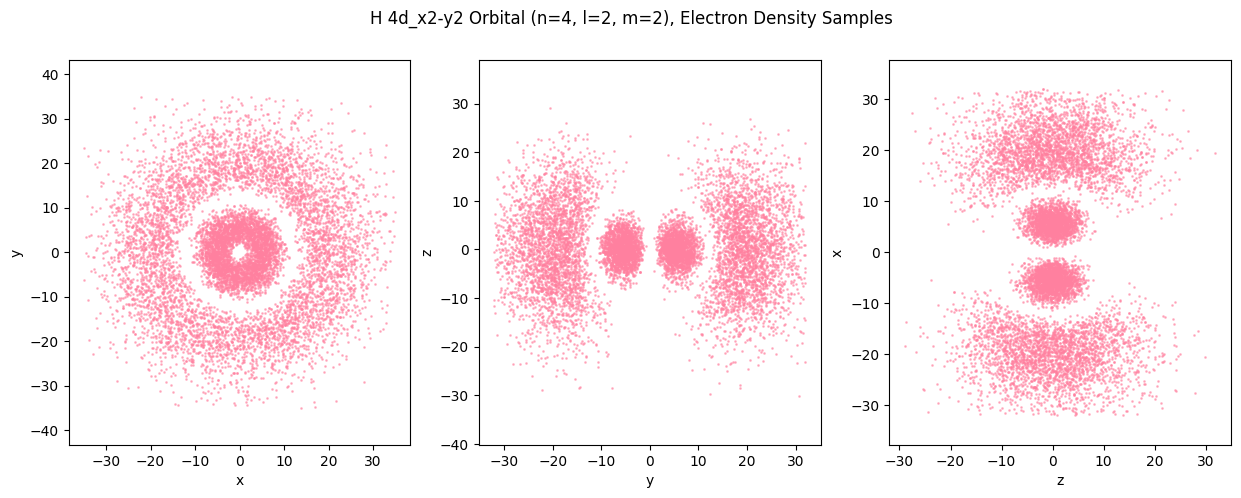

3.478186882135526e-29 34
4118.311614065307 27
4098.120087562133 27


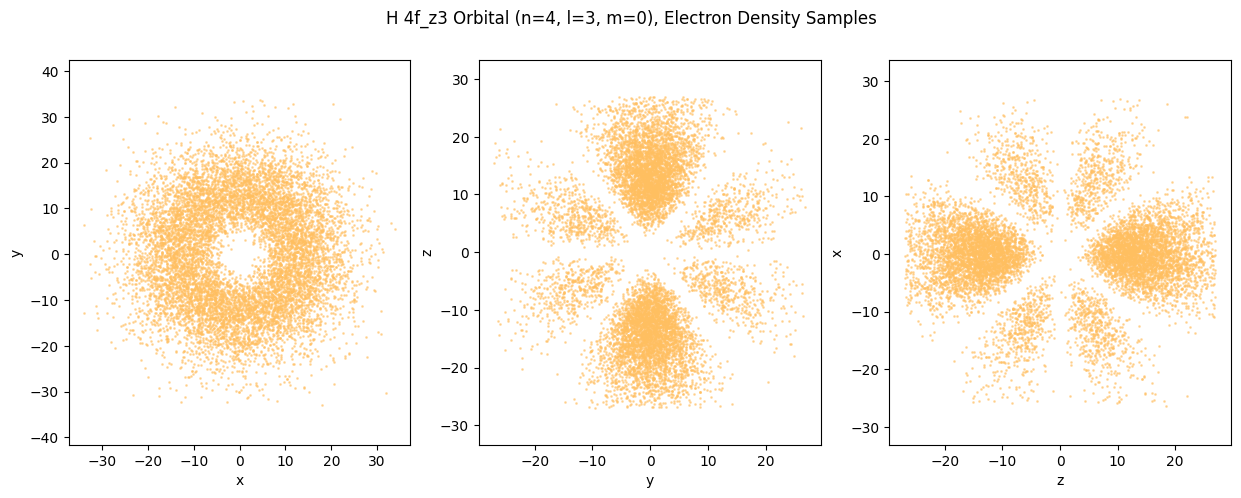

773.0539742927441 34
1448.4386560521414 33
1463.6524018782109 33


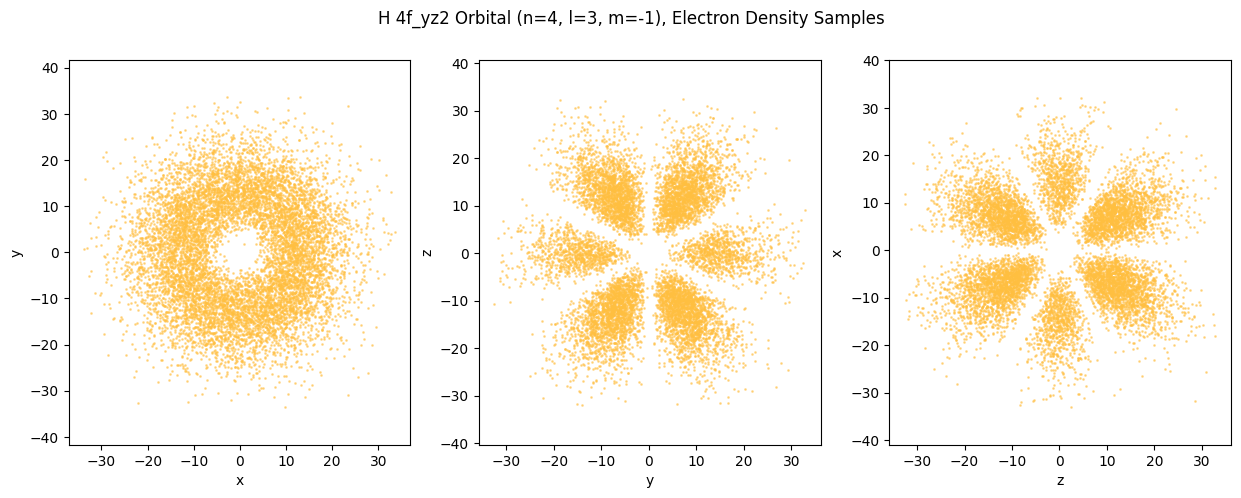

773.0526792894599 34
1458.9295637955295 33
1465.0979122330784 33


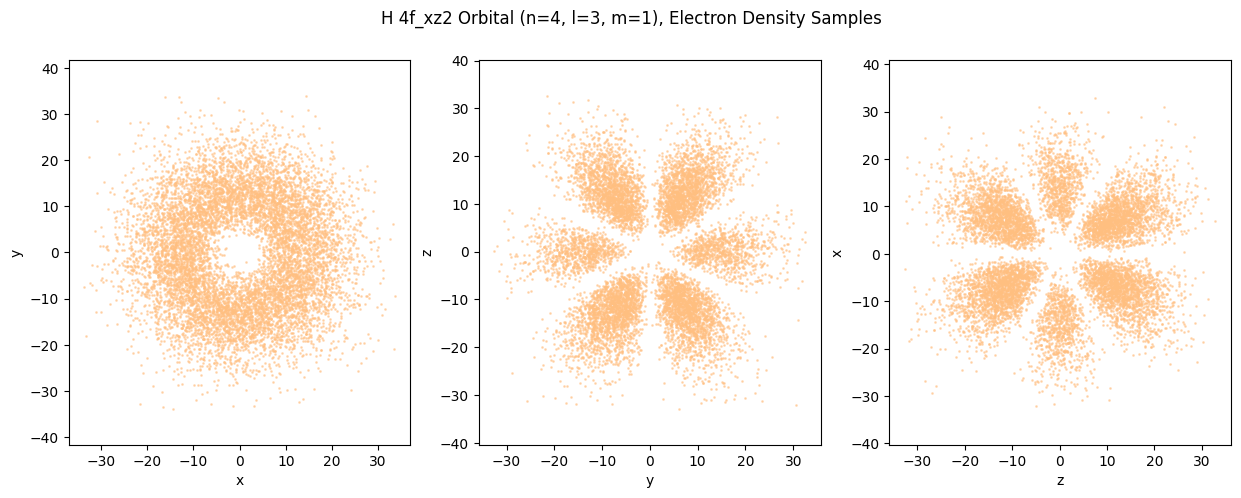

2.8984752871509694e-29 34
1144.5269020291676 33
1140.143525569769 33


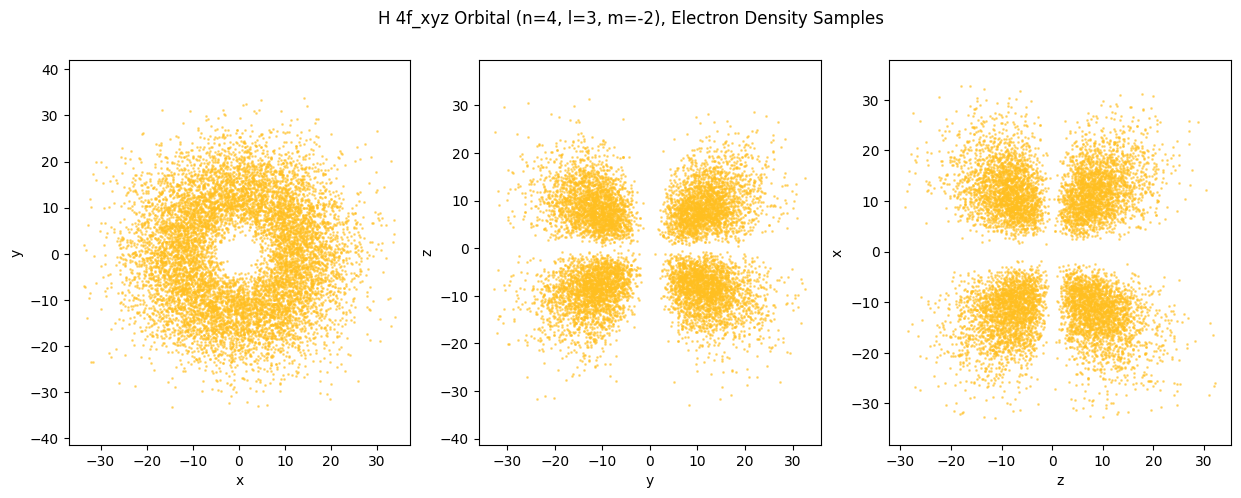

2.8984865013240653e-29 34
1143.9179075276716 33
1129.0294439455713 33


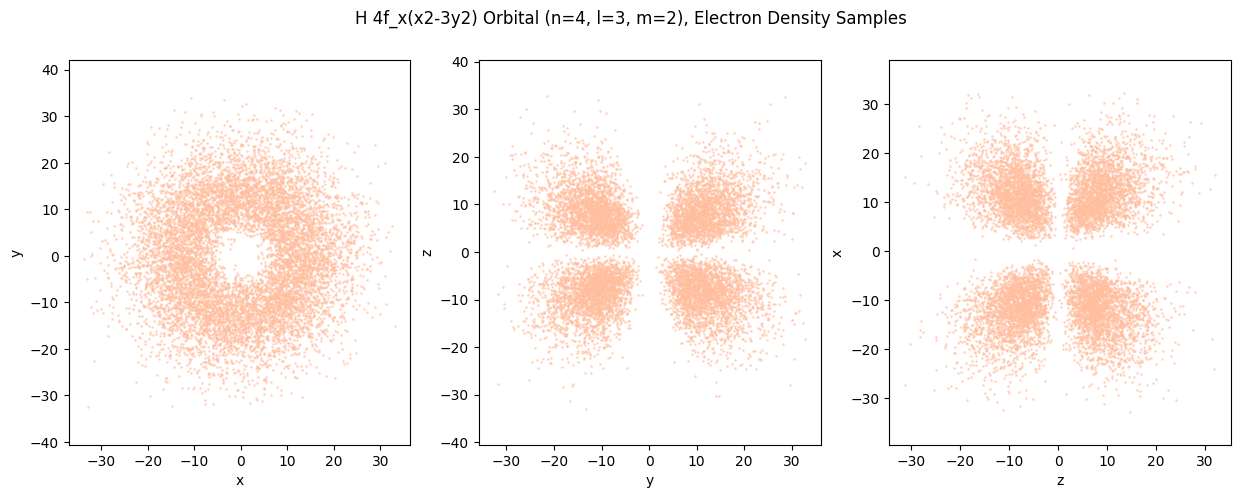

1288.4196749733508 34
1277.736815011129 30
1278.8780107608954 30


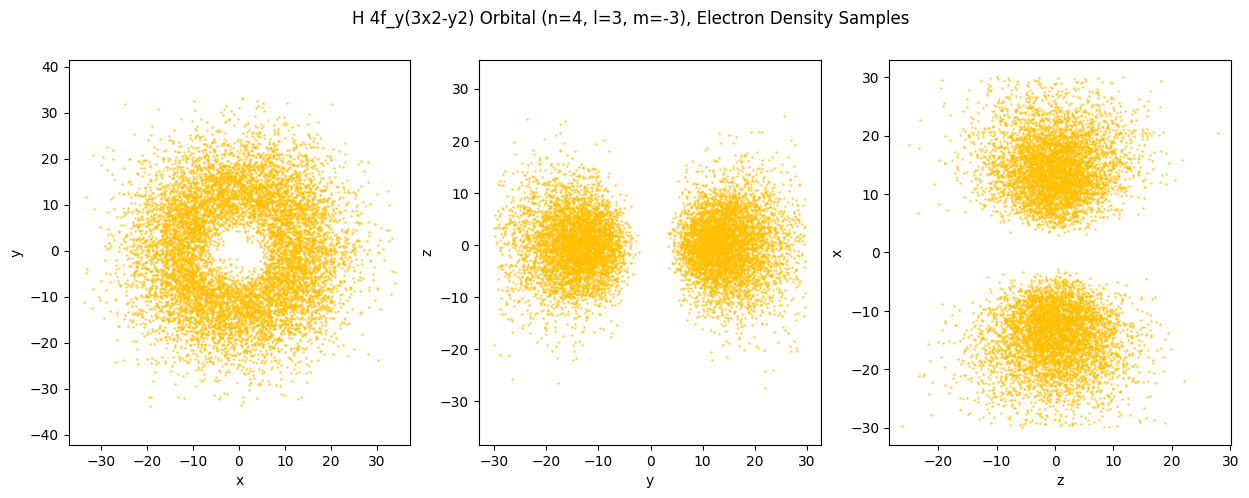

1288.422285186817 34
1281.1893138355156 30
1269.2491399033786 30


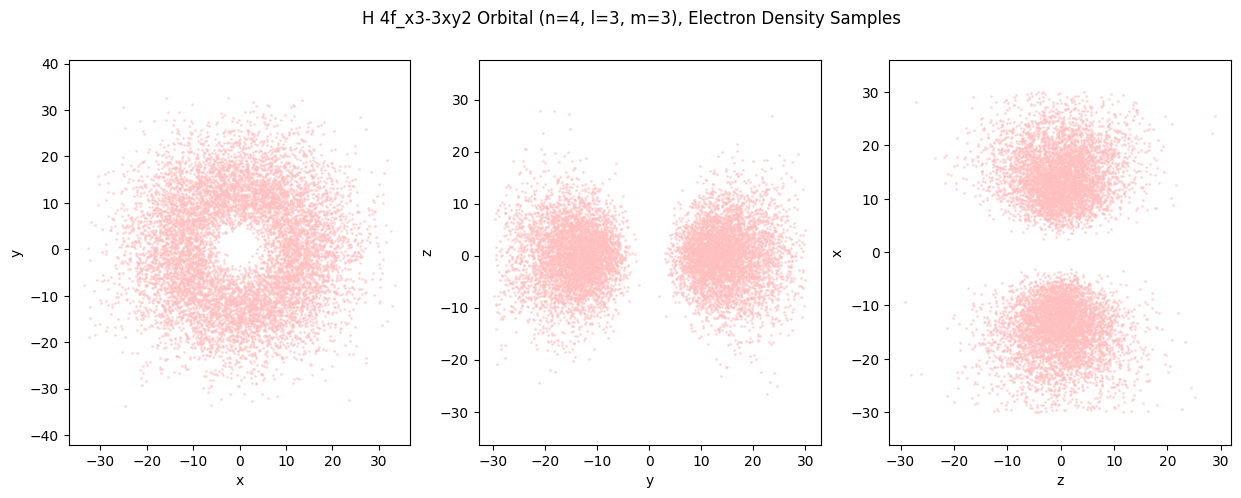

In [5]:
for key in orbital_names:
# key = (2, 1, 0)
    orbital = make_psi(*key)
    n, l, m = key
    samples = 10000
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    axes = (("x", "y"), ("y", "z"), ("z", "x"))

    for plane in range(3):
        pts = sample_distribution(orbital, n_samples=samples, plane=plane)
        color = (0.25 * n, 0.25 * l, 0.125 * (m + 3))
        ax[plane].scatter(pts[:, 0], pts[:, 1], s=1, color=color, alpha=0.5)
        ax[plane].axis('equal')
        ax[plane].set_xlabel(axes[plane][0])
        ax[plane].set_ylabel(axes[plane][1])

    fig.suptitle("H {name} Orbital (n={n}, l={l}, m={m}), Electron Density Samples".format(name=orbital_names[key], n=n, l=l, m=m))
    plt.show()